# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from tqdm import tqdm
import scipy.sparse as sp

import warnings
warnings.simplefilter('ignore')

from numpy.linalg import svd

from rectools.dataset import Dataset
from rectools.models import ImplicitItemKNNWrapperModel
from rectools.metrics import Precision, Recall, MeanInvUserFreq, Serendipity, calc_metrics
from rectools.metrics.ranking import MAP
from rectools.model_selection import TimeRangeSplitter, cross_validate

from implicit.evaluation import mean_average_precision_at_k



from implicit.nearest_neighbours import CosineRecommender, TFIDFRecommender, BM25Recommender
import os

In [ ]:
us = os.getcwd()

if 'liliyaivannikova' in us:
    PATH = r'/Users/liliyaivannikova/Documents/project/ml-latest/'
elif 'Владислав' in us:
    PATH = 'C:/Users/Владислав/test_python_scripts/project/test project/dataset/'
    
movies = pd.read_csv(PATH + r'movies.csv')
rating = pd.read_csv(PATH + r'ratings.csv')

-------

### Тестовая датасет на 1кк оценок (для быстрого тестирования моделей)

%%time
movies = pd.read_csv(
    "ml-1m/movies.dat",
    sep="::",
    engine="python",
    header=None,
    names=['movieId','title','genres'],
    encoding='latin-1'
)
rating = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    engine="python",
    header=None,
    names=['userId','movieId','rating','timestamp'],
)

-------------

In [3]:
print(f'''
movies: {movies.shape}
rating: {rating.shape}
''')


movies: (3883, 3)
rating: (1000209, 4)



In [4]:
movies.columns = [col.upper() for col in movies.columns]

movies['REALEASE'] = movies['TITLE'].str.extract("\((\d{4})\)", expand=True)
movies['REALEASE'] = pd.to_datetime(movies['REALEASE'], format='%Y')
movies['REALEASE'] = movies['REALEASE'].dt.year
movies['TITLE'] = movies['TITLE'].str[:-7]

dfx = movies['GENRES'].str.get_dummies(sep='|')
for col in dfx.columns:
    dfx[col] = dfx[col].astype('int8')

In [5]:
#movies = pd.concat([movies, dfx], axis=1) #.drop(columns=['GENRES'])
movies['TITLE'] = movies['TITLE'].astype('category')
movies['REALEASE'] = movies['REALEASE'].astype('float16')
movies['GENRES'] = movies['GENRES'].str.replace('|', ',')

In [6]:
rating.columns = [col.upper() for col in rating.columns]
rating['TIMESTAMP'] = pd.to_datetime(rating['TIMESTAMP'], unit='s')

# Обработка полей

In [7]:
rating_stat = rating.groupby('USERID')['MOVIEID'].count().reset_index()
rating_stat['MOVIEID'].quantile(0.05)

#rating_stat['FLAG_05'] = np.where(rating_stat['MOVIEID'] > rating_stat['MOVIEID'].quantile(0.05), 1, 0)
rating_stat['FLAG_05'] = np.where(rating_stat['MOVIEID'] > 20, 1, 0)

rating = rating.merge(rating_stat[['USERID', 'FLAG_05']], how = 'left', on = 'USERID')

rating.head()

,USERID,MOVIEID,RATING,TIMESTAMP,FLAG_05
0,1,1193,5,2000-12-31 22:12:40,1
1,1,661,3,2000-12-31 22:35:09,1
2,1,914,3,2000-12-31 22:32:48,1
3,1,3408,4,2000-12-31 22:04:35,1
4,1,2355,5,2001-01-06 23:38:11,1


In [8]:
print(rating.shape)
rating = rating[~((rating.TIMESTAMP.isna())|(rating.USERID.isna())|(rating.RATING.isna()))]
rating.query('USERID != 189614', inplace = True)
rating.query('FLAG_05 == 1', inplace = True)
print(rating.shape)

(1000209, 5)
(998489, 5)


In [9]:
agg_rat = rating[['USERID','RATING']].groupby('USERID')\
.agg('count')\
.dropna()\
.reset_index()\
.sort_values(['RATING'],ascending=False)

agg_rat

,USERID,RATING
4116,4169,2314
1660,1680,1850
4221,4277,1743
1920,1941,1595
1166,1181,1521
...,...,...
4057,4110,21
3449,3495,21
4492,4558,21
3846,3897,21


# Collaborative Filtering

In [10]:
def TrainTestSplit(df, n_days):
    '''
    df - датафрейм для разделения выборки
    n_days - количество дней, которые попадут в тест
    '''
    #df['weight'] = np.where(df['RATING'] >= 4, 1, 0)
    train_df = df.loc[df['datetime'] < df['datetime'].max() - pd.DateOffset(days=n_days)].copy()
    test_df = df.loc[df['datetime'] >= df['datetime'].max() - pd.DateOffset(days=n_days)].copy()

    return train_df, test_df


rating.rename({'USERID':'user_id',
            'MOVIEID':'item_id',
            'RATING':'weight',
            'TIMESTAMP':'datetime'}, axis=1, inplace=True)

train_df, test_df = TrainTestSplit(rating, 180)
train = Dataset.construct(train_df)
test = Dataset.construct(test_df)

def NewTrainTestSplit(df, n):
    '''
    df - датафрейм для разделения выборки
    n_days - количество дней, которые попадут в тест
    '''
    df['RN'] = df.sort_values(['user_id','datetime'], ascending=[True,False]).groupby(['user_id']).cumcount()+1
    
    train_df = df[df.RN > n].drop(['RN','FLAG_05'], axis=1)
    test_df = df[df.RN <= n].drop(['RN','FLAG_05'], axis=1)
    
    return train_df, test_df


rating.rename({'USERID':'user_id',
            'MOVIEID':'item_id',
            'RATING':'weight',
            'TIMESTAMP':'datetime'}, axis=1, inplace=True)

train_df, test_df = NewTrainTestSplit(rating, 10)
train = Dataset.construct(train_df)
test = Dataset.construct(test_df)

In [11]:
print(train_df.shape, test_df.shape)

(989680, 5) (8809, 5)


In [12]:
del rating

# Гиперпараметры, подбор

In [13]:
import os

# Get the number of available cores
num_cores = os.cpu_count()
num_cores

16

In [14]:
mapk_3 = {"name":"MAP@3","CosineRecommender": [], "TFIDFRecommender": [], "BM25Recommender": []}
mapk_5 = {"name":"MAP@5","CosineRecommender": [], "TFIDFRecommender": [], "BM25Recommender": []}
mapk_10 = {"name":"MAP@10","CosineRecommender": [], "TFIDFRecommender": [], "BM25Recommender": []}
mapk_20 = {"name":"MAP@20","CosineRecommender": [], "TFIDFRecommender": [], "BM25Recommender": []}
mapk_k = {"name":"MAP@kk","CosineRecommender": [], "TFIDFRecommender": [], "BM25Recommender": []}

k_list = np.arange(3, 104, 5)
m_list = [CosineRecommender, TFIDFRecommender, BM25Recommender]

for k in tqdm(k_list):
    for m in (m_list):
        model = ImplicitItemKNNWrapperModel(m(K=k, num_threads = 8))
        model.fit(train)

        reco = model.recommend(
            users=train_df.user_id.unique(),
            dataset=train,
            k=k,
            filter_viewed=True
        )

        mapk_3[m.__name__].extend([np.round(MAP(k=3).calc_per_user(reco, test_df).mean(),5)])
        mapk_5[m.__name__].extend([np.round(MAP(k=5).calc_per_user(reco, test_df).mean(),5)])
        mapk_10[m.__name__].extend([np.round(MAP(k=10).calc_per_user(reco, test_df).mean(),5)])
        mapk_20[m.__name__].extend([np.round(MAP(k=20).calc_per_user(reco, test_df).mean(),5)])
        mapk_k[m.__name__].extend([np.round(MAP(k=k).calc_per_user(reco, test_df).mean(),5)])
    

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [04:07<00:00, 11.81s/it]


# Результаты на тестовых данных

In [15]:
def plot_map(l):
    for i in l:
        mapk_cos = np.array(i['CosineRecommender'])*100
        mapk_tfidf = np.array(i['TFIDFRecommender'])*100
        mapk_bm25 = np.array(i['BM25Recommender'])*100

        fig = plt.figure(figsize=(10,4))

        plt.plot(k_list, mapk_cos, markersize=8)
        plt.plot(k_list, mapk_tfidf, markersize=8)
        plt.plot(k_list, mapk_bm25, markersize=8)

        plt.xlabel('Число соседей, k', fontsize=12)
        plt.ylabel('Качество модеи, MAP@K, %', fontsize=12)
        plt.title(f'Динамика {i["name"]} в зависимости от числа соседей', fontsize=12)
        plt.legend(['Cosine', 'TF-IDF', 'BM25'])
        plt.grid(True)
        plt.savefig(f'knn_{i["name"]}_v1.png')
        plt.show()

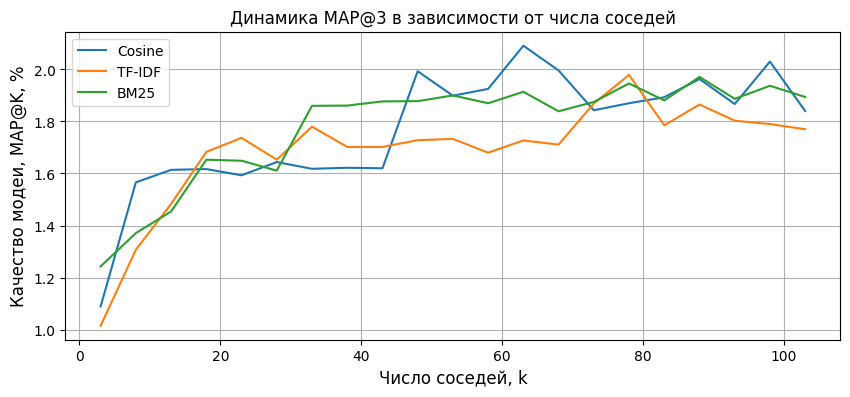

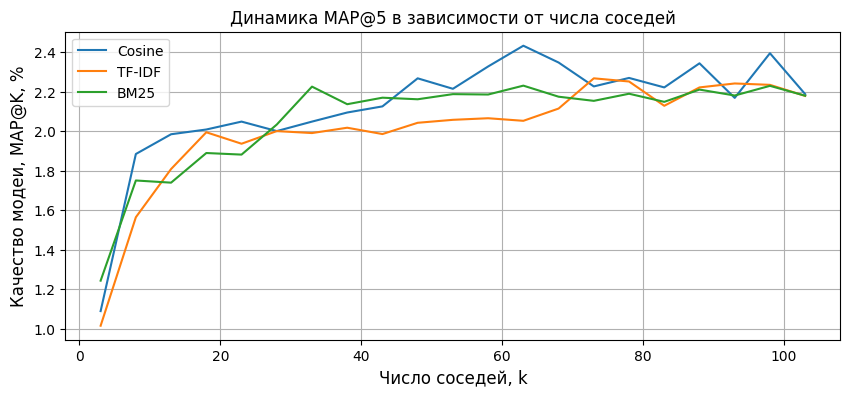

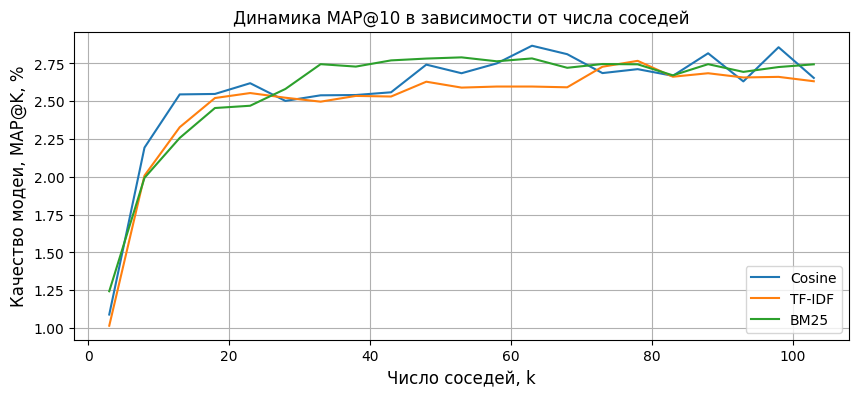

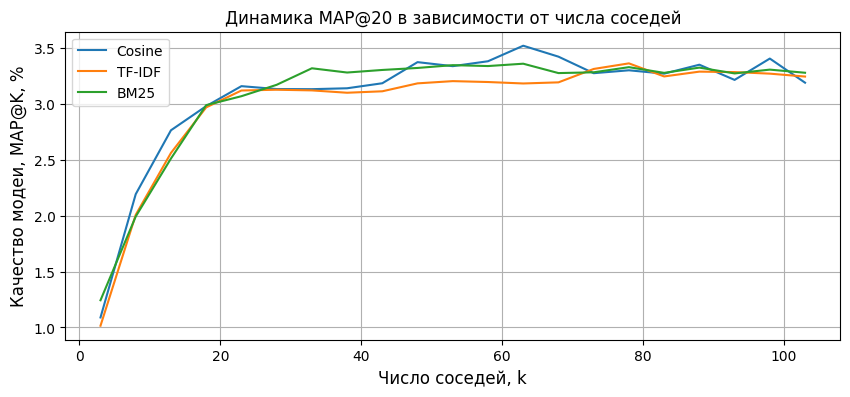

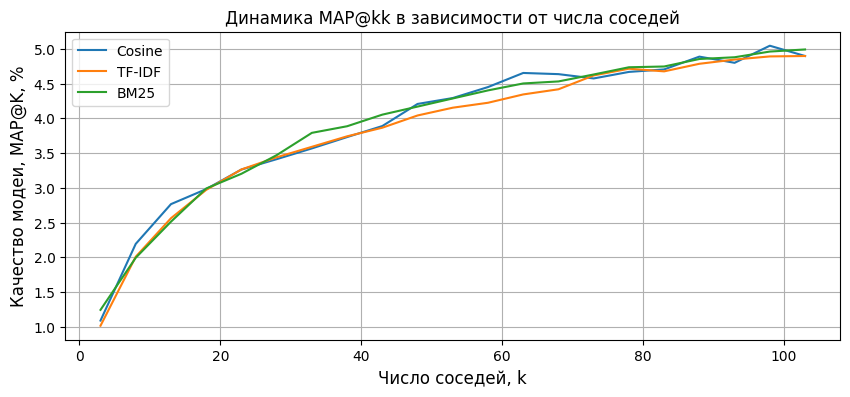

In [17]:
plot_map([mapk_3,mapk_5,mapk_10,mapk_20,mapk_k])

n_splits = 3

splitter = TimeRangeSplitter(
    test_size="14D",
    n_splits=n_splits,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=True,
)

splitter.get_test_fold_borders(train.interactions)

# Take few simple models to compare
models = {
    "tfidf_k=5": ImplicitItemKNNWrapperModel(model=TFIDFRecommender(K=5)),
    "tfidf_k=10": ImplicitItemKNNWrapperModel(model=TFIDFRecommender(K=10)),
    "bm25_k=10_k1=0.05_b=0.1": ImplicitItemKNNWrapperModel(model=BM25Recommender(K=5, K1=0.05, B=0.1)),
}

# We will calculate several classic (precision@k and recall@k) and "beyond accuracy" metrics
metrics = {
    "prec@1": Precision(k=1),
    "prec@10": Precision(k=10),
    "recall": Recall(k=10),
    "novelty": MeanInvUserFreq(k=10),
    "serendipity": Serendipity(k=10),
    "MAP@k": MAP(k=10).calc_per_user(reco, test_df).mean()
}

K_RECS = 10

cv_results = cross_validate(
    dataset=train,
    splitter=splitter,
    models=models,
    metrics=metrics,
    k=K_RECS,
    filter_viewed=True,
)

pd.DataFrame(cv_results["splits"])

pd.DataFrame(cv_results["metrics"])

pivot_results = (
    pd.DataFrame(cv_results["metrics"])
    .drop(columns="i_split")
    .groupby(["model"], sort=False)
    .agg(["mean"])#, "std"])
)
mean_metric_subset = [(metric, "mean") for metric in pivot_results.columns.levels[0]]
(
    pivot_results.style
    .highlight_min(subset=mean_metric_subset, color='lightcoral', axis=0)
    .highlight_max(subset=mean_metric_subset, color='lightgreen', axis=0)
)